<a href="https://colab.research.google.com/github/Amayomiee/BigData/blob/main/Clustering_%26_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')
Flamingo = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/combined-data.csv")

Mounted at /content/drive


In [3]:
Flamingo = Flamingo.rename(columns=lambda x: x.strip()) #removes whitespaces from headers if exists

In [4]:
#pinkFlam.fillna(pinkFlam.mean(), inplace=True)
print('Samples with Purchases : ' + str(Flamingo['avg_price'].count()) + ' from  the total samples : ' + str(Flamingo['userId'].count())) 

Samples with Purchases : 1411 from  the total samples : 4619


In [5]:
Flamingo.replace("NULL", np.nan, inplace=True)

In [ ]:
print(Flamingo.head(10))

In [8]:
Flamingo.dropna(inplace=True)
print(Flamingo.head(10))

    userId  userSessionId  teamLevel platformType  count_gameclicks  \
4      937           5652          1      android                39   
11    1623           5659          1       iphone               129   
13      83           5661          1      android               102   
17     121           5665          1      android                39   
18     462           5666          1      android                90   
31     819           5679          1       iphone                51   
49    2199           5697          1      android                51   
50    1143           5698          1      android                47   
58    1652           5706          1      android                46   
61    2222           5709          1       iphone                41   

    count_hits  count_buyId  avg_price  
4            0          1.0        1.0  
11           9          1.0       10.0  
13          14          1.0        5.0  
17           4          1.0        3.0  
18          1

In [ ]:
print(Flamingo.head(10))

In [ ]:
!apt-get install openjdk-8-jdk-headless

In [11]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2023-05-19 06:32:22--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  9.94MB/s    in 35s     

2023-05-19 06:32:57 (7.51 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [12]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz

In [13]:
!pip install -q findspark

In [14]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [15]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [16]:
import pyspark
import numpy as np
import pandas as pd

In [17]:
df = Flamingo

In [18]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert the Pandas DataFrame to PySpark DataFrame
spark_df = spark.createDataFrame(df)

# Define the stages for the pipeline
indexer = StringIndexer(inputCol='platformType', outputCol='platformTypeIndex')
encoder = OneHotEncoder(inputCol='platformTypeIndex', outputCol='platformTypeVec')
assembler = VectorAssembler(inputCols=['teamLevel', 'count_gameclicks', 'count_hits', 'count_buyId', 'platformTypeVec'],
                            outputCol='features')

# Create the pipeline
pipeline = Pipeline(stages=[indexer, encoder, assembler])

# Fit the pipeline to the data
pipeline_model = pipeline.fit(spark_df)

# Apply the pipeline to transform the data
transformed_df = pipeline_model.transform(spark_df)


In [19]:
# Retrieve the distinct values of the platformType column
class_labels = transformed_df.select('platformType').distinct().rdd.flatMap(lambda x: x).collect()

# Print the class labels
for label in class_labels:
    print(f'Class Label: {label}')


Class Label: iphone
Class Label: android
Class Label: linux
Class Label: mac
Class Label: windows


In [25]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['teamLevel', 'count_gameclicks', 'count_hits', 'count_buyId'],
    outputCol='newFeatures'  # Choose a different name for the output column
)

output = assembler.transform(transformed_df)

(trainingData, testData) = output.randomSplit([0.8, 0.2], seed=123)


In [26]:
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, NaiveBayes

dt = DecisionTreeClassifier(labelCol='platformTypeIndex', featuresCol='newFeatures')  # Update the featuresCol to 'newFeatures'
dtModel = dt.fit(trainingData)

lr = LogisticRegression(labelCol='platformTypeIndex', featuresCol='newFeatures')
lrModel = lr.fit(trainingData)

naiveBayes = NaiveBayes(labelCol='platformTypeIndex', featuresCol='newFeatures')
naiveBayesModel = naiveBayes.fit(trainingData)

dtPredictions = dtModel.transform(testData)
lrPredictions = lrModel.transform(testData)
naiveBayesPredictions = naiveBayesModel.transform(testData)

In [27]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, NaiveBayes
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd

dt = DecisionTreeClassifier(labelCol='platformTypeIndex', featuresCol='newFeatures')
dtModel = dt.fit(trainingData)

lr = LogisticRegression(labelCol='platformTypeIndex', featuresCol='newFeatures')
lrModel = lr.fit(trainingData)

nb = NaiveBayes(labelCol='platformTypeIndex', featuresCol='newFeatures')
nbModel = nb.fit(trainingData)

dtPredictions = dtModel.transform(testData)
lrPredictions = lrModel.transform(testData)
nbPredictions = nbModel.transform(testData)

# Convert PySpark DataFrame to Pandas DataFrame
dtPreds_pd = dtPredictions.select(['platformTypeIndex', 'prediction']).toPandas()
lrPreds_pd = lrPredictions.select(['platformTypeIndex', 'prediction']).toPandas()
nbPreds_pd = nbPredictions.select(['platformTypeIndex', 'prediction']).toPandas()

# Extract predicted labels and true labels
dtPreds_labels = dtPreds_pd['prediction'].tolist()
dtTrue_labels = dtPreds_pd['platformTypeIndex'].tolist()

lrPreds_labels = lrPreds_pd['prediction'].tolist()
lrTrue_labels = lrPreds_pd['platformTypeIndex'].tolist()

nbPreds_labels = nbPreds_pd['prediction'].tolist()
nbTrue_labels = nbPreds_pd['platformTypeIndex'].tolist()

# Compute accuracy, precision, and recall scores using scikit-learn
dtAccuracy = accuracy_score(dtTrue_labels, dtPreds_labels)
dtPrecision = precision_score(dtTrue_labels, dtPreds_labels, average='weighted')
dtRecall = recall_score(dtTrue_labels, dtPreds_labels, average='weighted')

lrAccuracy = accuracy_score(lrTrue_labels, lrPreds_labels)
lrPrecision = precision_score(lrTrue_labels, lrPreds_labels, average='weighted')
lrRecall = recall_score(lrTrue_labels, lrPreds_labels, average='weighted')

nbAccuracy = accuracy_score(nbTrue_labels, nbPreds_labels)
nbPrecision = precision_score(nbTrue_labels, nbPreds_labels, average='weighted')
nbRecall = recall_score(nbTrue_labels, nbPreds_labels, average='weighted')

# Print the scores
print('Decision Tree Accuracy:', dtAccuracy)
print('Decision Tree Precision:', dtPrecision)
print('Decision Tree Recall:', dtRecall)

print('Logistic Regression Accuracy:', lrAccuracy)
print('Logistic Regression Precision:', lrPrecision)
print('Logistic Regression Recall:', lrRecall)

print('Naive Bayes Accuracy:', nbAccuracy)
print('Naive Bayes Precision:', nbPrecision)
print('Naive Bayes Recall:', nbRecall)

Decision Tree Accuracy: 0.39097744360902253
Decision Tree Precision: 0.28496046317343743
Decision Tree Recall: 0.39097744360902253
Logistic Regression Accuracy: 0.38345864661654133
Logistic Regression Precision: 0.28208308240863855
Logistic Regression Recall: 0.38345864661654133
Naive Bayes Accuracy: 0.37969924812030076
Naive Bayes Precision: 0.3023276184466733
Naive Bayes Recall: 0.37969924812030076


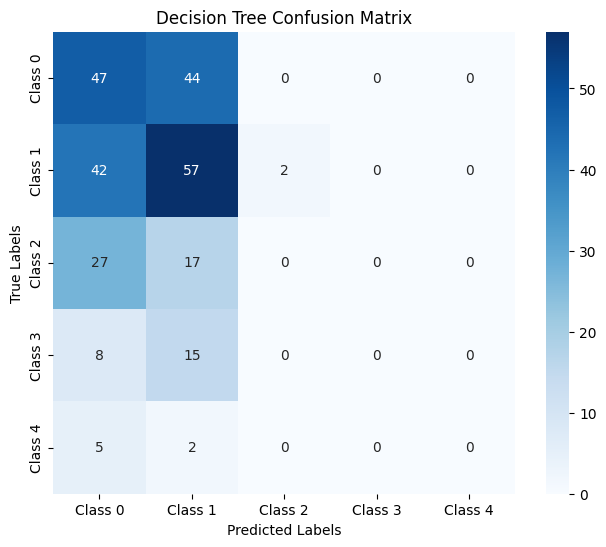

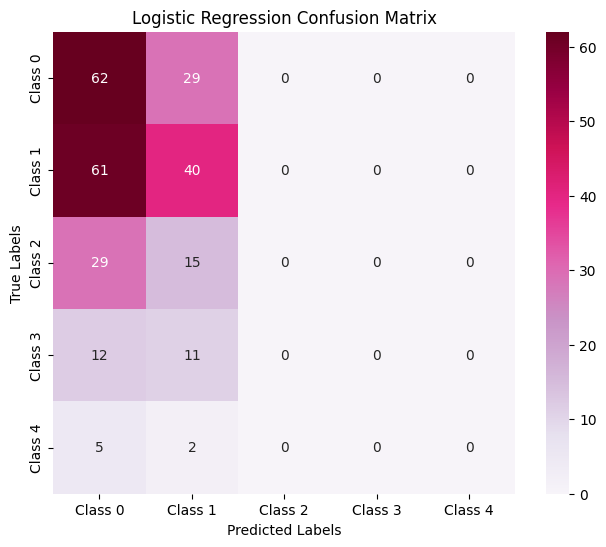

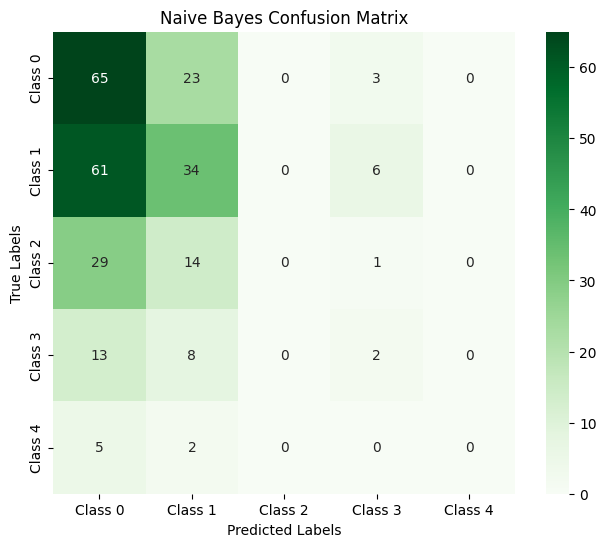

In [29]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix using scikit-learn
dtConfusionMatrix = confusion_matrix(dtTrue_labels, dtPreds_labels)
lrConfusionMatrix = confusion_matrix(lrTrue_labels, lrPreds_labels)
nbConfusionMatrix = confusion_matrix(nbTrue_labels, nbPreds_labels)

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(dtConfusionMatrix, annot=True, cmap='Blues', fmt='d', square=True,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Decision Tree Confusion Matrix')
plt.show()

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(lrConfusionMatrix, annot=True, cmap='PuRd', fmt='d', square=True,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Plot confusion matrix for Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(nbConfusionMatrix, annot=True, cmap='Greens', fmt='d', square=True,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

Clustering using K-means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare your data for clustering
features = ['count_gameclicks', 'count_hits', 'count_buyId', 'avg_price']
data = Flamingo[features]  

# Normalize the features
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Apply K-means clustering
k = 5  # Number of clusters (change as needed)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(normalized_data)

# Get the cluster labels for each instance
cluster_labels = kmeans.labels_

# Add the cluster labels to your DataFrame
df['cluster_label'] = cluster_labels

# Analyze the clusters
for cluster in range(k):
    cluster_data = df[df['cluster_label'] == cluster]
    print(f"Cluster {cluster} - Count: {len(cluster_data)}")
    print(cluster_data['platformType'].value_counts())  # Count of platform types in the cluster
    print('\n')



Cluster 0 - Count: 638
android    326
windows    136
iphone      87
linux       66
mac         23
Name: platformType, dtype: int64


Cluster 1 - Count: 375
iphone     318
android     45
mac          7
windows      5
Name: platformType, dtype: int64


Cluster 2 - Count: 35
android    14
iphone     10
linux       6
windows     4
mac         1
Name: platformType, dtype: int64


Cluster 3 - Count: 203
iphone     81
android    69
windows    37
linux      12
mac         4
Name: platformType, dtype: int64


Cluster 4 - Count: 160
iphone     59
android    59
windows    21
linux      12
mac         9
Name: platformType, dtype: int64




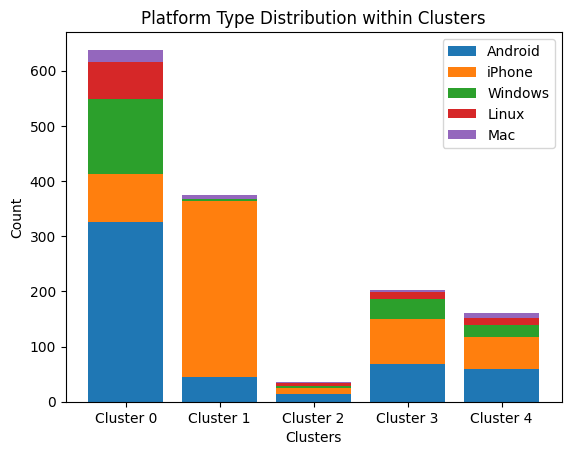

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data (example data)
data = {
    'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
    'android': [326, 45, 14, 69, 59],
    'iphone': [87, 318, 10, 81, 59],
    'windows': [136, 5, 4, 37, 21],
    'linux': [66, 0, 6, 12, 12],
    'mac': [23, 7, 1, 4, 9]
}

df = pd.DataFrame(data)

# Set the cluster labels as the x-axis
clusters = df['Cluster']

# Set the platform types and their counts or proportions
platforms = ['android', 'iphone', 'windows', 'linux', 'mac']
platform_counts = df[platforms]

# Create the stacked bar chart
plt.bar(clusters, platform_counts['android'], label='Android', color='tab:blue')
plt.bar(clusters, platform_counts['iphone'], bottom=platform_counts['android'], label='iPhone', color='tab:orange')
plt.bar(clusters, platform_counts['windows'], bottom=platform_counts['android'] + platform_counts['iphone'], label='Windows', color='tab:green')
plt.bar(clusters, platform_counts['linux'], bottom=platform_counts['android'] + platform_counts['iphone'] + platform_counts['windows'], label='Linux', color='tab:red')
plt.bar(clusters, platform_counts['mac'], bottom=platform_counts['android'] + platform_counts['iphone'] + platform_counts['windows'] + platform_counts['linux'], label='Mac', color='tab:purple')

# Customize the plot
plt.xlabel('Clusters')
plt.ylabel('Count')
plt.title('Platform Type Distribution within Clusters')
plt.legend()

# Show the plot
plt.show()
